In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Define date range
dates = pd.date_range(start="2023-01-01", end="2023-12-31", freq="D")

# Generate a list of products
products = [f"Product_{i}" for i in range(1, 51)]

# Generate data
data = {
    "date": np.random.choice(dates, size=5000),
    "product_id": np.random.choice(products, size=5000),
    "category": np.random.choice(["Electronics", "Clothing", "Home Goods"], size=5000),
    "sales_quantity": np.random.poisson(lam=10, size=5000),  # Base sales volume
    "stock_remaining": np.random.randint(50, 500, size=5000),  # Simulated inventory level
    "location": np.random.choice(["Warehouse_A", "Warehouse_B", "Warehouse_C"], size=5000),
    "price": np.random.uniform(10, 500, size=5000).round(2),  # Product price
    "promotion": np.random.choice([0, 1], size=5000, p=[0.8, 0.2]),  # 20% on promotion
    "is_holiday": np.random.choice([0, 1], size=5000, p=[0.9, 0.1]),  # 10% holiday dates
}

# Create the DataFrame
df = pd.DataFrame(data)

# Add time-based features for forecasting
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek  # 0=Monday, 6=Sunday
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
df["month"] = pd.to_datetime(df["date"]).dt.month
df["quarter"] = pd.to_datetime(df["date"]).dt.quarter

# Simulate demand seasonality (e.g., higher sales in December)
df["sales_quantity"] += (df["month"] == 12).astype(int) * np.random.poisson(lam=5, size=len(df))

# Add reorder point and lead time
df["reorder_point"] = np.random.randint(20, 100, size=len(df))
df["lead_time"] = np.random.randint(2, 10, size=len(df))  # Days for restocking

# Sort by date for time-series analysis
df = df.sort_values(by=["product_id", "date"]).reset_index(drop=True)

# Save to CSV
df.to_csv("enhanced_inventory_forecasting_data.csv", index=False)

print("Synthetic dataset generated and saved as 'enhanced_inventory_forecasting_data.csv'")


Synthetic dataset generated and saved as 'enhanced_inventory_forecasting_data.csv'


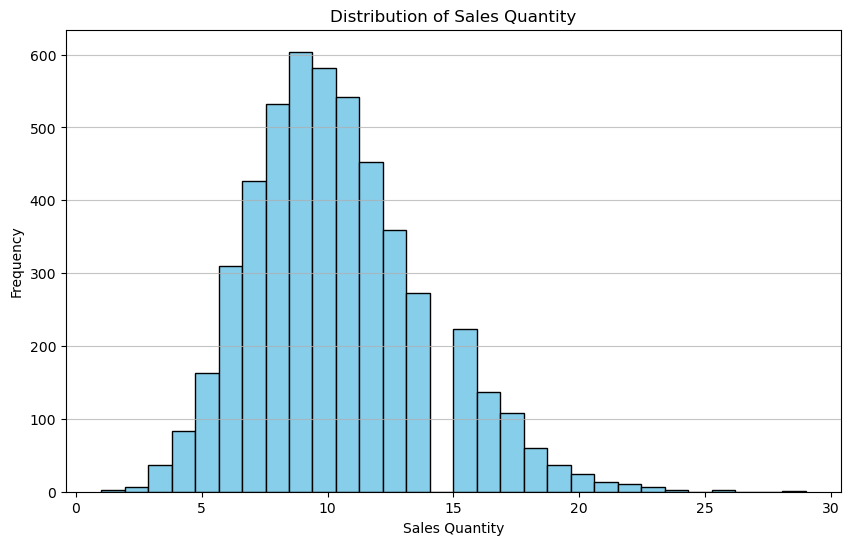

In [2]:
# Plot the distribution of sales_quantity
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["sales_quantity"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sales Quantity")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.savefig("sales_quantity_distribution.png")




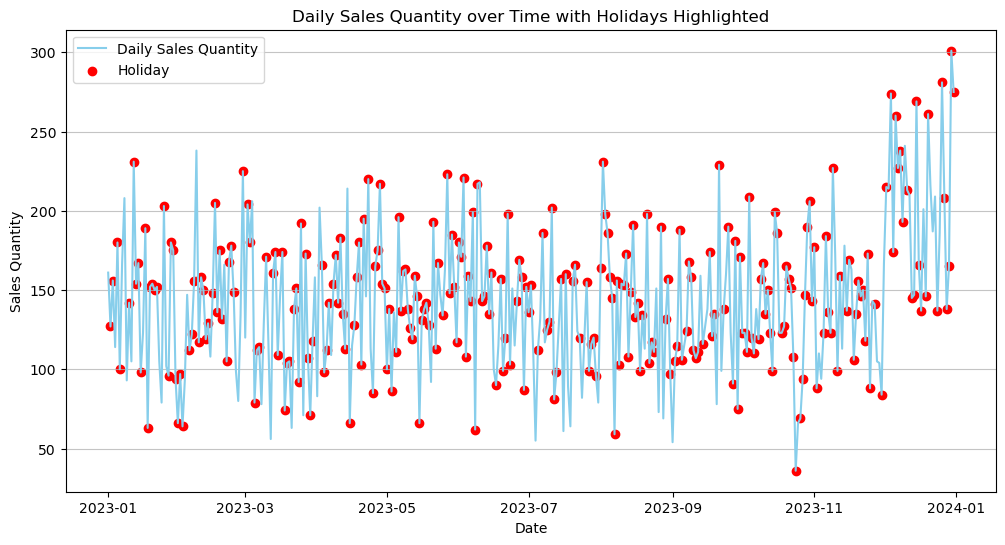

In [3]:
# Compare sales quantity during holidays vs. non-holidays

# Group by date and sum sales quantity
daily_sales = df.groupby("date")["sales_quantity"].sum().reset_index()
daily_sales["is_holiday"] = df.groupby("date")["is_holiday"].max().values


# Plot daily sales quantity
plt.figure(figsize=(12, 6))
plt.plot(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", label="Daily Sales Quantity")
plt.scatter(
    daily_sales[daily_sales["is_holiday"] == 1]["date"],
    daily_sales[daily_sales["is_holiday"] == 1]["sales_quantity"],
    color="red",
    label="Holiday",
)
plt.title("Daily Sales Quantity over Time with Holidays Highlighted")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.savefig("daily_sales_quantity_holidays.png")


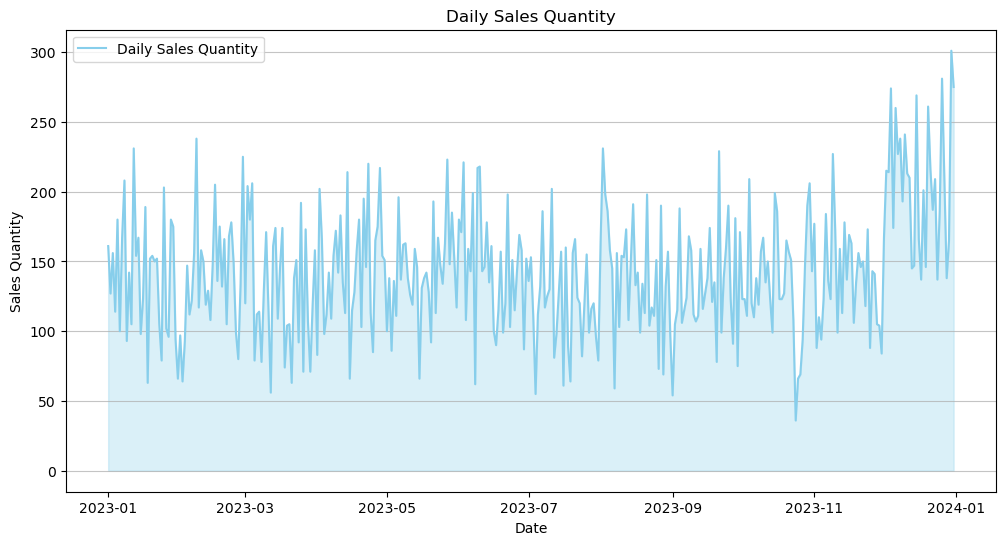

In [4]:
# Plot daily sales quantity

plt.figure(figsize=(12, 6))
plt.plot(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", label="Daily Sales Quantity")
plt.fill_between(daily_sales["date"], daily_sales["sales_quantity"], color="skyblue", alpha=0.3)
plt.title("Daily Sales Quantity")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.grid(axis="y", alpha=0.75)
plt.legend()
plt.savefig("daily_sales_quantity.png")

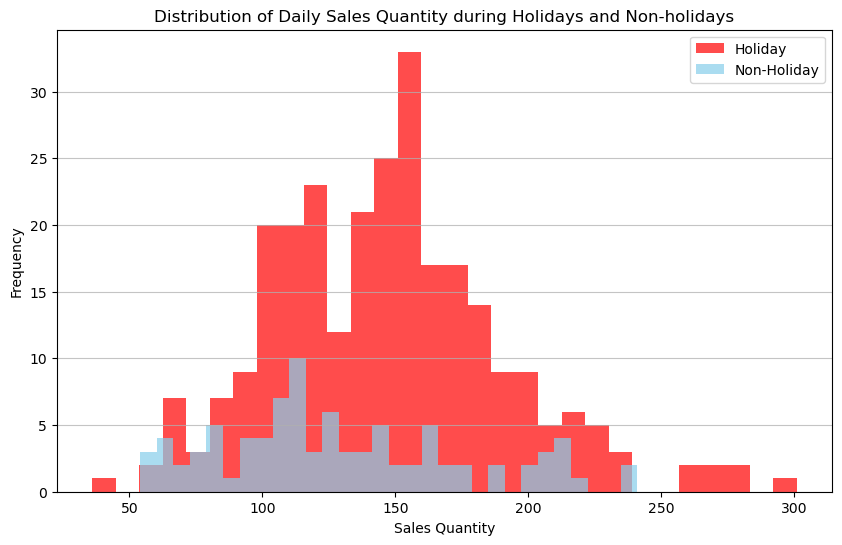

In [5]:
# Plot sales quantity during holidays vs. non-holidays

plt.figure(figsize=(10, 6))
plt.hist(daily_sales[daily_sales["is_holiday"] == 1]["sales_quantity"], bins=30, color="red", alpha=0.7, label="Holiday")
plt.hist(daily_sales[daily_sales["is_holiday"] == 0]["sales_quantity"], bins=30, color="skyblue", alpha=0.7, label="Non-Holiday")
plt.title("Distribution of Daily Sales Quantity during Holidays and Non-holidays")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.savefig("daily_sales_quantity_holidays_distribution.png")


In [7]:
# Forecasting sales quantity using ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Filter data for a specific product
product_id = "Product_1"
product_data = df[df["product_id"] == product_id].copy()

# Group by date and sum sales quantity
product_sales = product_data.groupby("date")["sales_quantity"].sum().reset_index()



In [8]:
# Train-test split
train_size = int(len(product_sales) * 0.8)
train_sales = product_sales[:train_size]["sales_quantity"]
test_sales = product_sales[train_size:]["sales_quantity"]

# Fit ARIMA model
model = ARIMA(train_sales, order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_sales))
forecast_index = product_sales[train_size:].index

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_sales, forecast))



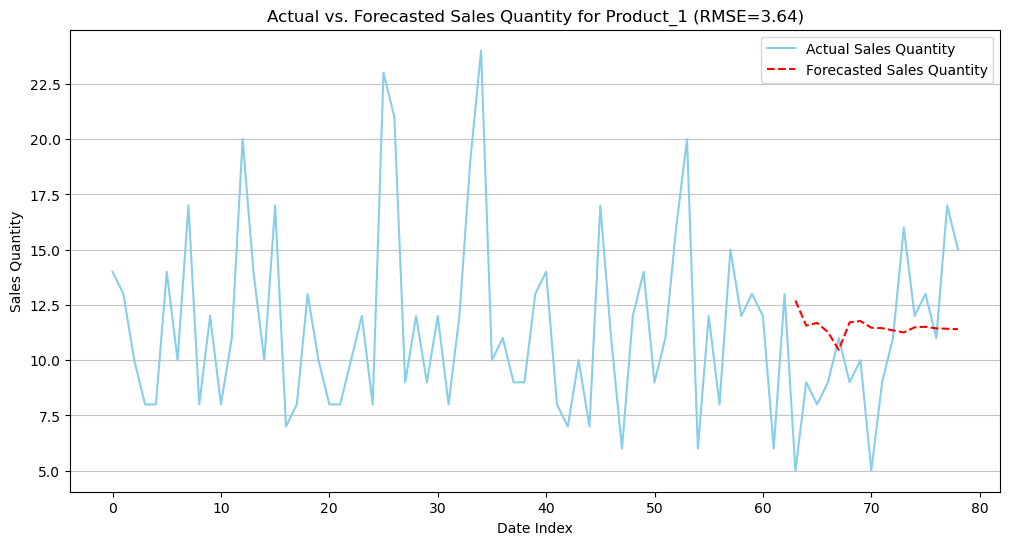

In [9]:
# Plot actual vs. forecasted sales quantity
plt.figure(figsize=(12, 6))
plt.plot(product_sales.index, product_sales["sales_quantity"], color="skyblue", label="Actual Sales Quantity")
plt.plot(forecast_index, forecast, color="red", linestyle="--", label="Forecasted Sales Quantity")
plt.title(f"Actual vs. Forecasted Sales Quantity for {product_id} (RMSE={rmse:.2f})")
plt.xlabel("Date Index")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(axis="y", alpha=0.75)
plt.savefig("arima_forecast_sales_quantity.png")